In [1]:
import json
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
import pandas as pd
from netpyne import sim, specs

savedata = 1 # Save Netpyne and BBP soma_voltage

--No graphics will be displayed.


In [2]:
# !nrnivmodal mod/

In [3]:
from netpyne import sim, specs
import pickle

# Define simulation configuration
cfg = specs.SimConfig()

cfg.duration = 3300  # ms
cfg.dt = 0.025  # Time step
cfg.seeds = {'cell': 4321, 'conn': 4321, 'stim': 1234, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -75.85}  # Set temperature and initial voltage
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.5

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

allpops = ['HL23PYR_' + str(i) for i in range(1, 23)]

cfg.recordCells = allpops  # which cells to record from
cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'},
                    # 'V_axon_0': {'sec':'axon_0', 'loc':0.5, 'var':'v'},                  
                    # 'V_dend_5': {'sec':'dend_5', 'loc':0.5, 'var':'v'},
                    }

## Dict with traces to record
cfg.recordStim = True
cfg.recordTime = True
cfg.recordStep = 0.025
cfg.saveDataInclude = ['simData', 'simConfig', 'netParams'] 

cfg.simLabel = 'L23_Pyr'
cfg.saveFolder = '.'
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			##  
cfg.saveCellConns = True		##  

cfg.analysis['plotTraces'] = {'include': allpops, 'figSize': (12, 6), 'timeRange': [2000,cfg.duration], 'saveFig': False, 'overlay': True, 'oneFigPer': 'trace'}  # Plot recorded traces for this list of cells


In [4]:
# Define network parameters
netParams = specs.NetParams()

cellModels = ['HH_full']
Epops = ['HL23PYR']

cellName = 'HL23PYR'
cellRule = netParams.importCellParams(label=cellName, somaAtOrigin=True,
        conds={'cellType': cellName, 'cellModel': 'HH_full'},
        fileName='cellwrapper.py',
        cellName='loadCell_' + cellName,
        cellInstance = True,
        cellArgs={'cellName': cellName})

NeuronTemplate_HL23PYR[0]


In [5]:
# # Define populations
# allpops = ['HL23PYR_' + str(i) for i in range(1, 23)]  # 22 cells (sweeps)
# for popName in allpops:
#     netParams.popParams[popName] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1}

# # Define IClamp step current protocol based on Allen dataset
# cfg.IClamp = []
# step_currents = np.array([-110, -90, -70, -50, -30, -10, 10, 30, 70, 90, 110, 130, 150, 
#                           170, 170, 170, 170, 190, 210, 230, 250, 270, 290, 310]) / 1000  # Convert to nA
# step_currents = step_currents[:len(allpops)]  # Match number of cells
# start_time = 1020  # ms
# duration = 1000  # ms

# for i, popName in enumerate(allpops):
#     cfg.IClamp.append({'pop': popName, 'sec': 'soma_0', 'loc': 0.5, 'start': start_time, 'dur': duration, 'amp': step_currents[i]})
#     netParams.stimSourceParams[f'IClamp_{i}'] = {'type': 'IClamp', 'delay': start_time, 'dur': duration, 'amp': step_currents[i]}
#     netParams.stimTargetParams[f'IClamp_{i}_{popName}'] = {'source': f'IClamp_{i}', 'conds': {'pop': popName}, 'sec': 'soma_0', 'loc': 0.5}

In [6]:
#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
cellName = 'HL23PYR'
for popName in allpops:
    netParams.popParams[popName] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 

#------------------------------------------------------------------------------
# Current inputs (IClamp)
#------------------------------------------------------------------------------

cfg.IClamp = []

# Parameters
n_cells = len(allpops)  # 
current_start = -0.110  # Initial Current (nA)
current_end = 0.310  # Final Current (nA)
current_step = 0.020  # Increment Step


#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------

cfg.IClamp = []
cfg.IClampnumber = 0
    
for i, popName in enumerate(allpops):
    cfg.IClamp.append({'pop': popName, 'sec': 'soma_0', 'loc': 0.5, 'start': 2100, 'dur': 1000, 'amp':current_start + i * current_step}) #pA
    cfg.IClampnumber=cfg.IClampnumber+1


#------------------------------------------------------------------------------
# Current inputs (IClamp)
#------------------------------------------------------------------------------
for j in range(cfg.IClampnumber):
        key ='IClamp'
        params = getattr(cfg, key, None)
        key ='IClamp'+str(j+1)
        params = params[j]
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}
        
        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': sec, 
            'loc': loc} 

In [7]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
sim.net.defineCellShapes()  # in case some cells had stylized morphologies without 3d pts
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.net.defineCellShapes()


Start time:  2025-03-16 16:23:22.713294

Creating network of 22 cell populations on 1 hosts...
  Number of cells on node 0: 22 
  Done; cell creation time = 0.53 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 22 
  Done; cell stims creation time = 0.00 s.
Recording 44 traces of 2 types on node 0


In [8]:
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc
sim.analysis.plotShape()  

0.0s

Running simulation using NEURON for 3300.0 ms...
0.5s
1.0s
1.5s
2.0s
2.5s
3.0s
  Done; run time = 83.53 s; real-time ratio: 0.04.

Gathering data...
  Done; gather time = 0.37 s.

Analyzing...
  Cells: 22
  Connections: 0 (0.00 per cell)
  Spikes: 192 (2.64 Hz)
  Simulated time: 3.3 s; 1 workers
  Run time: 83.53 s
   HL23PYR_1 : 0.000 Hz
   HL23PYR_2 : 0.000 Hz
   HL23PYR_3 : 0.000 Hz
   HL23PYR_4 : 0.000 Hz
   HL23PYR_5 : 0.000 Hz
   HL23PYR_6 : 0.000 Hz
   HL23PYR_7 : 0.000 Hz
   HL23PYR_8 : 0.000 Hz
   HL23PYR_9 : 0.000 Hz
   HL23PYR_10 : 2.121 Hz
   HL23PYR_11 : 3.030 Hz
   HL23PYR_12 : 3.333 Hz
   HL23PYR_13 : 3.636 Hz
   HL23PYR_14 : 3.939 Hz
   HL23PYR_15 : 4.242 Hz
   HL23PYR_16 : 4.545 Hz
   HL23PYR_17 : 4.848 Hz
   HL23PYR_18 : 5.152 Hz
   HL23PYR_19 : 5.455 Hz
   HL23PYR_20 : 5.758 Hz
   HL23PYR_21 : 6.061 Hz
   HL23PYR_22 : 6.061 Hz
Plotting recorded cell traces ... trace
  Done; plotting time = 0.16 s

Total time = 84.63 s
Plotting 3D cell shape ...


(<Figure size 640x480 with 1 Axes>, {})

In [9]:
# Calculate firing rate
spk_times = sim.simData['spkt']  # Spike Times
spk_ids = sim.simData['spkid']  # Neuron's ID

steps, rates = np.unique(spk_ids, return_counts=True)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

plt.figure(figsize=(8, 4))

# Define time range
start_time, end_time = 2100, 3100

# Convert time array to NumPy for indexing
time_array = np.array(sim.simData['t'])

# Find indices corresponding to the desired time range
time_indices = np.where((time_array >= start_time) & (time_array <= end_time))

# Find a cell that spikes
spiking_cell = None
available_cells = list(sim.simData['V_soma'].keys())

for cell in available_cells:
    voltage_trace = np.array(sim.simData['V_soma'][cell])  # Convert to NumPy array
    peaks, _ = find_peaks(voltage_trace, height=-20)  # Detect spikes above -20 mV
    if len(peaks) > 0:  # If this cell has spikes, select it
        spiking_cell = cell
        break

# Plot the voltage trace of the spiking cell
if spiking_cell:
    plt.plot(time_array[time_indices], np.array(sim.simData['V_soma'][spiking_cell])[time_indices], label=f"Spiking Cell: {spiking_cell}")
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.title(f'Voltage Trace for {spiking_cell} (1000-3000 ms)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ No spiking cells found in sim.simData['V_soma']!")


Injected currents (pA): [-110.  -90.  -70.  -50.  -30.  -10.   10.   30.   50.   70.   90.  110.
  130.  150.  170.  190.  210.  230.  250.  270.  290.  310.]
Firing rates (Hz): [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  7. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 20.]


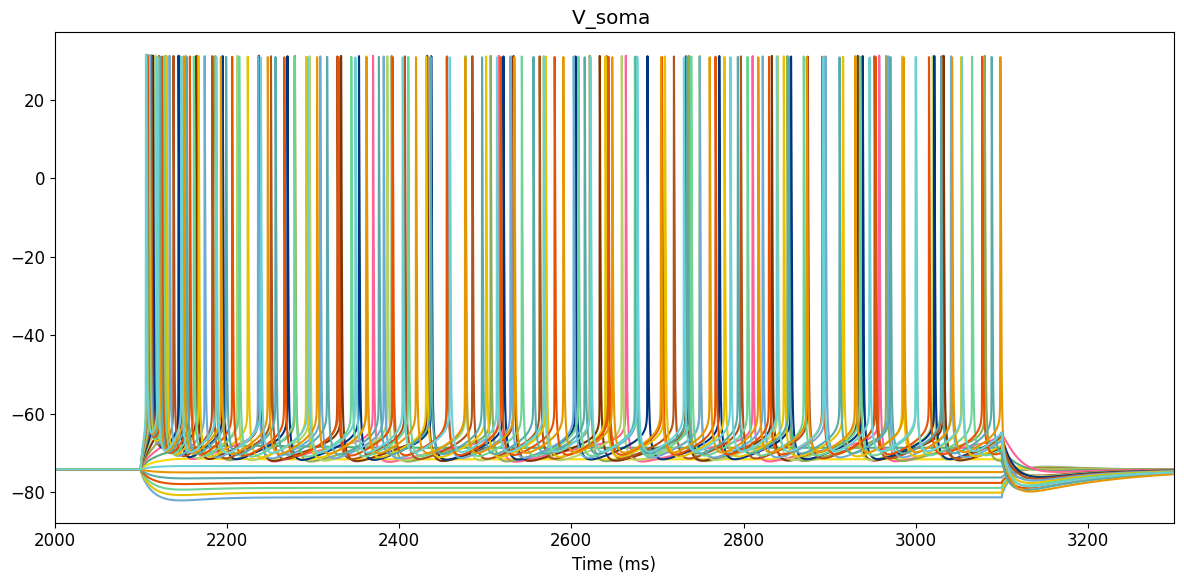

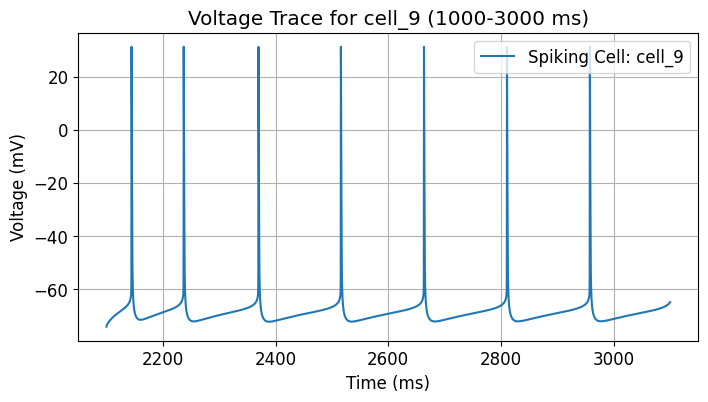

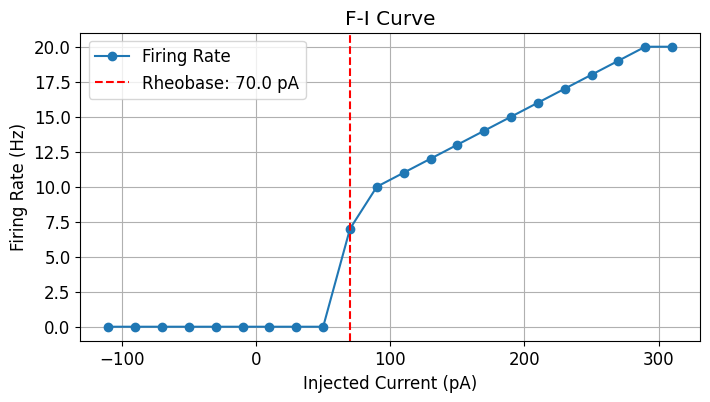

Rheobase Current: 70.0 pA


In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Define simulation parameters
duration = 1000  # Stimulation duration in ms
step_currents = np.arange(-110, 320, 20) / 1000  # Convert pA to nA

# Extract spike times and neuron IDs
spk_times = np.array(sim.simData['spkt'])  # Spike times
spk_ids = np.array(sim.simData['spkid']).astype(int)  # Ensure IDs are integers

# Ensure neuron IDs match the number of step currents
valid_neurons = spk_ids[(spk_ids >= 0) & (spk_ids < len(step_currents))]

# Initialize spike counts for each step current
spike_counts = np.zeros(len(step_currents), dtype=int)

# Count spikes per neuron (mapped to step current)
unique_neurons, counts = np.unique(valid_neurons, return_counts=True)

for neuron, count in zip(unique_neurons, counts):
    spike_counts[neuron] = count  # Assign spike count

# Compute firing rates (Hz)
firing_rates = spike_counts / (duration / 1000)  # Convert to Hz

# Determine the first current step that generates at least one spike
rheobase = None
for i, amp in enumerate(step_currents):
    spike_count = np.sum((spk_times >= 1200) & (spk_times <= 2200) & (spk_ids == i))
    if spike_count > 0:
        rheobase = amp * 1000  # Convert to pA
        break

# Debugging check
print(f"Injected currents (pA): {step_currents * 1000}")
print(f"Firing rates (Hz): {firing_rates}")

# Plot F-I Curve
plt.figure(figsize=(8, 4))
plt.plot(step_currents * 1000, firing_rates, marker='o', linestyle='-', label='Firing Rate')
plt.axvline(rheobase, color='r', linestyle='--', label=f"Rheobase: {rheobase:.1f} pA")
plt.xlabel('Injected Current (pA)')
plt.ylabel('Firing Rate (Hz)')
plt.title('F-I Curve')
plt.grid(True)
plt.legend()
plt.show()

print(f"Rheobase Current: {rheobase:.1f} pA")


In [12]:
time = np.array(sim.simData['t'])
time[np.logical_and(time>=2000, time<=2100)]

array([2000.   , 2000.025, 2000.05 , ..., 2099.925, 2099.95 , 2099.975])

Injected currents (pA): [-110  -90  -70  -50  -30  -10   10   30]
Steady-state voltages (mV): [-81.36297568 -80.17435874 -78.94845049 -77.67880595 -76.35417273
 -74.95337143 -73.43142029 -71.66596094]


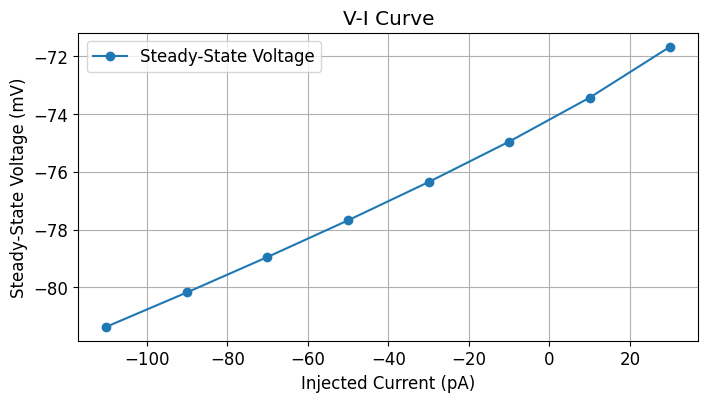

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Define current step protocol (pA → nA)
step_currents = np.arange(-110, 40, 20)   
num_sweeps = len(step_currents)

# Extract simulation data
time = np.array(sim.simData['t'])  # Time array
voltage_traces = {cell: np.array(sim.simData['V_soma'][cell]) for cell in sim.simData['V_soma']}

# Initialize array for steady-state voltage (last 100ms of stimulation)
V_ss = np.zeros(num_sweeps)

# Extract steady-state voltage for each step current
for i, (cell, v_trace) in enumerate(voltage_traces.items()):
    if i >= num_sweeps:  # Ensure we only process expected sweeps
        break
    # Find steady-state voltage at the end of the stimulation
    V_ss[i] = np.mean(v_trace[np.logical_and(time>=3000, time<=3100)])  # Last 100ms avg DURING THE STIMULLUS 

# Debugging check
print(f"Injected currents (pA): {step_currents}")
print(f"Steady-state voltages (mV): {V_ss}")

# Plot V-I Curve
plt.figure(figsize=(8, 4))
plt.plot(step_currents, V_ss, marker='o', linestyle='-', label='Steady-State Voltage')
plt.xlabel('Injected Current (pA)')
plt.ylabel('Steady-State Voltage (mV)')
plt.title('V-I Curve')
plt.grid(True)
plt.legend()
plt.show()
